# **RSNA-MICCAI Brain Tumor Radiogenomic Classification**
**Predict the status of a genetic biomarker important for brain cancer treatment**

# **Imports and variable declarations**

This section contains the libraries used in the notebook as well as the variables relating to the parameters of the generated network.

In [1]:
import os # os functionalities
import re # regular expressions
import numpy as np # linear algebra
import pandas as pd # data processing
from skimage import io # image manipulation
from matplotlib import pyplot as plt # image visualization

import seaborn as sns

# Tensorflow & Keras & SkLearn
import keras
import tensorflow as tf
#warnings.filterwarnings('ignore')
from keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split # divide dataset
from sklearn.metrics import classification_report, confusion_matrix # confusion matrix

In [2]:
# Variable declaration
image_mode = "FLAIR" # FLAIR - T1w - T1wCE - T2w
patient_mode = "central" # central - first TODO: Explain 
input_dir = "../input/rsna-miccai-png/train" 
target_dir = "../input/rsna-miccai-png/test"

# Model variables
epochs = 5
batch_size = 8
learning_rate = 0.001
optimizer = "RMSprop"
loss_function = "binary_crossentropy"


# **Data loading**

In [3]:
# Get path to the training images
input_img_paths_patients = sorted([
    os.path.join(input_dir, fname + "/" + image_mode) 
    for fname in os.listdir(input_dir)
    if os.path.exists(os.path.join(input_dir, fname + "/" + image_mode))])

# Read images
input_img_paths = []
for patient in input_img_paths_patients:
    # TODO: Explain
    # TODO: Choosing first makes no sense. Because of the way images are taken. Center or bigger
    images_id = x = [int(re.findall(r'\d+', x)[0]) for x in os.listdir(patient)] # Get all image ids
    if patient_mode == "central":
        index_central_image = min(images_id) + round((max(images_id) - min(images_id))/2) # Get middle image
        path = os.path.join(patient, "Image-" + str(index_central_image) + ".png")
        if os.path.exists(path): input_img_paths.append(path)
    if patient_mode == "first":
        index_central_image = min(images_id) # Get first image
        path = os.path.join(patient, "Image-" + str(index_central_image) + ".png")
        if os.path.exists(path): input_img_paths.append(path)
            
# Read csv labels
df = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')

# Obtain pure labels
labels = []
for img_path in input_img_paths:
    labels.append(df.loc[df['BraTS21ID'] == int(re.findall(r'\d+', img_path)[0])]['MGMT_value'].iloc[0])

In [4]:
# Split data into train, validation and test
X_train, X_test, y_train, y_test = train_test_split(input_img_paths, labels, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.111, random_state=42) # 0.111*0.9 = 0.1

# Check amounts of data in each split
print(f"Training samples: {str(len(X_train))}\nValidation samples: {str(len(X_val))}\nTest samples: {str(len(X_test))}")

# Create dataframes for keras flow_from_dataframe
data = {'id': X_train, 'label': [str(x) for x in y_train]}
train_df = pd.DataFrame(data)

data = {'id': X_val, 'label': [str(x) for x in y_val]}
val_df = pd.DataFrame(data)

data = {'id': X_test, 'label': [str(x) for x in y_test]}
test_df = pd.DataFrame(data)

Training samples: 464
Validation samples: 59
Test samples: 59


In [5]:
def load_dataset(train_df, val_df, test_df, data_augmentation=False):
    """
    This function loads the dataset from dataset folder
    :parameter train_df: Dataframe with paths to training images and labels
    :parameter val_df: Dataframe with paths to validation images and labels
    :parameter test_df: Dataframe with paths to test images and labels
    :parameter data_augmentation: Boolean indicating whether to include or not data augmentation
    :return train_generator: Training generator
    :return val_generator: Validation generator
    :return test_generator: Testing generator
    """

    # Create a data generator
    if data_augmentation:
        datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0,
                                                                        rotation_range=20,
                                                                        width_shift_range=0.1,
                                                                        height_shift_range=0.1,
                                                                        zoom_range=0.2,
                                                                        horizontal_flip=True)
    else:
        datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
        
    datagen_val_test = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

    # Load and iterate training dataset
    train_generator=datagen_train.flow_from_dataframe(dataframe=train_df, x_col="id", y_col="label", 
                                                      class_mode="binary", batch_size=batch_size, target_size=(224, 224))
    # Load and iterate validation dataset
    val_generator=datagen_val_test.flow_from_dataframe(dataframe=val_df, x_col="id", y_col="label", 
                                                       class_mode="binary", batch_size=batch_size, target_size=(224, 224))
    # Load and iterate test dataset
    test_generator=datagen_val_test.flow_from_dataframe(dataframe=test_df, x_col="id", y_col="label", 
                                                        class_mode="binary", batch_size=batch_size, target_size=(224, 224))

    return train_generator, val_generator, test_generator

## **Data visualization**

Text(0.5, 1.0, 'Tumor presence: 0')

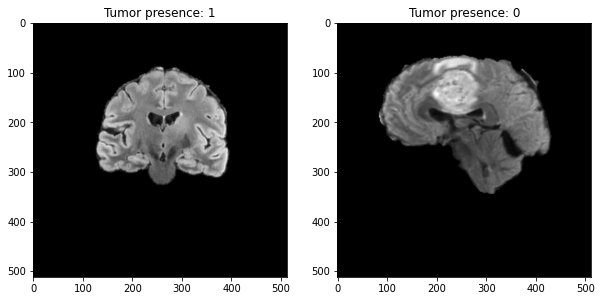

In [6]:
# Read training images and visualize
i = 0
while labels[0] == labels[i]: 
    i+=1

# Create figure
fig = plt.figure(figsize=(10, 10))

# Cetting values to rows and column variables
rows = 1
columns = 2

# Plot images - Visualize an image and it's segmentation
fig.add_subplot(rows, columns, 1)
plt.imshow(io.imread(input_img_paths[0]), cmap='gray')
plt.title(f"Tumor presence: {labels[0]}")

fig.add_subplot(rows, columns, 2)
plt.imshow(io.imread(input_img_paths[i]), cmap='gray')
plt.title(f"Tumor presence: {labels[i]}")

In [7]:
# Load dataset
train_generator, val_generator, test_generator = load_dataset(train_df, val_df, test_df)

Found 464 validated image filenames belonging to 2 classes.
Found 59 validated image filenames belonging to 2 classes.
Found 59 validated image filenames belonging to 2 classes.


# **Model definition**

In [8]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = keras.models.Sequential()
model.add(VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(4096, activation='relu'))
model.add(tf.keras.layers.Dense(2048, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

2022-12-08 10:58:22.397923: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 10:58:22.503276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 10:58:22.504116: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 10:58:22.505995: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              102764544 
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2049      
Total params: 125,871,937
Trainable params: 125,871,937
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Choose optimizer - SGD - RMSprop - Adam
if optimizer == "SGD": 
    fit_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, decay=learning_rate/epochs)
elif optimizer == "RMSprop":
    fit_optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, decay=learning_rate/epochs)
else: 
    fit_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-7, amsgrad=True)

# **Model training**

In [10]:
# Configure the model for training.
model.compile(optimizer=fit_optimizer, loss=loss_function, metrics=['accuracy'])

# Safe best model
callbacks = [keras.callbacks.ModelCheckpoint("lesion_segmentaion.h5", save_best_only=True)]

# Train the model, doing validation at the end of each epoch.
model_history = model.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=callbacks)

# Serialize and save model to json
'''model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)'''
    
# Serialize and save weights to HDF5
'''model.save_weights("model.h5")
print("Saved model to disk")'''

2022-12-08 10:58:27.990421: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-12-08 10:58:30.218771: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


58/58 [==============================] - 15s 110ms/step - loss: 26818.3145 - accuracy: 0.5043 - val_loss: 0.6911 - val_accuracy: 0.5424
Epoch 2/5
58/58 [==============================] - 6s 97ms/step - loss: 0.6933 - accuracy: 0.5194 - val_loss: 0.6909 - val_accuracy: 0.5424
Epoch 3/5
58/58 [==============================] - 6s 95ms/step - loss: 0.6926 - accuracy: 0.5065 - val_loss: 0.6928 - val_accuracy: 0.5424
Epoch 4/5
58/58 [==============================] - 5s 94ms/step - loss: 0.6934 - accuracy: 0.5194 - val_loss: 0.6918 - val_accuracy: 0.5424
Epoch 5/5
58/58 [==============================] - 6s 95ms/step - loss: 0.6931 - accuracy: 0.5194 - val_loss: 0.6911 - val_accuracy: 0.5424


'model.save_weights("model.h5")\nprint("Saved model to disk")'

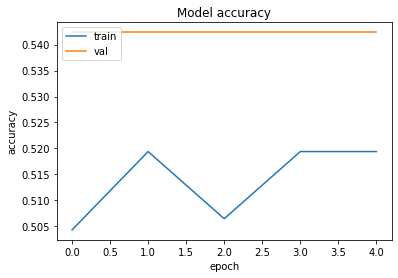

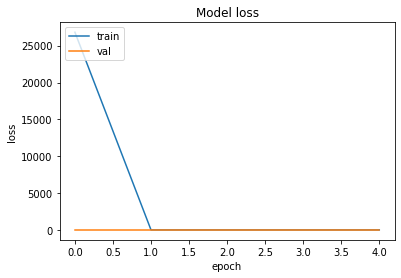

In [11]:
def create_plots(history_plot):
    """
    This functions creates the plots accuracy and loss evolution in training and validation
    :param history_plot: Record of training loss values and metrics values at successive epochs
    :return: It saves the accuracy and loss plots
    """
    # Accuracy plot
    plt.plot(history_plot.history['accuracy'])
    plt.plot(history_plot.history['val_accuracy'])
    plt.title(f'Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(f'MAMe_accuracy.pdf')
    plt.show()
    plt.close()

    # Loss plot
    plt.plot(history_plot.history['loss'])
    plt.plot(history_plot.history['val_loss'])
    plt.title(f'Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(f'MAMe_loss.pdf')
    plt.show()

create_plots(model_history)

In [12]:
# Evaluate the model
test_generator.reset()
score = model.evaluate(test_generator, verbose=0)

print(f"Loss: {str(score[0])} \nAccuracy on test: {str(score[1])}\n")

'''# Confusion Matrix (validation subset)
test_generator.reset()
pred = model.predict(test_generator, verbose=0)

# Assign most probable label
predicted_class_indices = np.argmax(pred, axis=1)

# Get class labels
labels = (test_generator.class_indices)
target_names = labels.keys()

# Plot statistics
classification_report(test_generator.classes, predicted_class_indices, target_names=target_names)

# Plot confusion matrix
cf_matrix = confusion_matrix(np.array(test_generator.classes), predicted_class_indices)
fig, ax = plt.subplots(figsize=(15, 15))
heatmap = sns.heatmap(cf_matrix, annot=False, cmap='Blues', cbar=True, square=False,
                      xticklabels=target_names, yticklabels=target_names)
fig = heatmap.get_figure()'''

Loss: 0.6901720762252808 
Accuracy on test: 0.5593220591545105



"# Confusion Matrix (validation subset)\ntest_generator.reset()\npred = model.predict(test_generator, verbose=0)\n\n# Assign most probable label\npredicted_class_indices = np.argmax(pred, axis=1)\n\n# Get class labels\nlabels = (test_generator.class_indices)\ntarget_names = labels.keys()\n\n# Plot statistics\nclassification_report(test_generator.classes, predicted_class_indices, target_names=target_names)\n\n# Plot confusion matrix\ncf_matrix = confusion_matrix(np.array(test_generator.classes), predicted_class_indices)\nfig, ax = plt.subplots(figsize=(15, 15))\nheatmap = sns.heatmap(cf_matrix, annot=False, cmap='Blues', cbar=True, square=False,\n                      xticklabels=target_names, yticklabels=target_names)\nfig = heatmap.get_figure()"